## DETR fine-tune
* 參考資料
    * [woctezuma finetune-detr](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb)
    * [NielsRogge DETR](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb)
    * [colab fine-tune detr](https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb)

In [7]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False)

2.0.1 True


## 準備 custom 資料集
* 參考資料
    * [labelme2coco](https://github.com/fcakyon/labelme2coco)

In [2]:
# !pip install -U labelme2coco
from labelme2coco import get_coco_from_labelme_folder, save_json

# set labelme training data directory
labelme_train_folder = "C:\\Users\\samel\\Documents\\ntou_workplace\\data\\analysingdata\\5fold\\folder0\\train\\"
# set labelme validation data directory
labelme_val_folder = "C:\\Users\\samel\\Documents\\ntou_workplace\\data\\analysingdata\\5fold\\folder0\\val\\"
# set path for coco json to be saved
export_dir = "C:\\Users\\samel\\Documents\\ntou_workplace\\data\\analysingdata\\5fold\\folder0\\"

# create train coco object
train_coco = get_coco_from_labelme_folder(labelme_train_folder)
# export train coco json
save_json(train_coco.json, export_dir+"custom_train.json")

# create val coco object
val_coco = get_coco_from_labelme_folder(labelme_val_folder, coco_category_list=train_coco.json_categories)
# export val coco json
save_json(val_coco.json, export_dir+"custom_val.json")

There are 93 listed files in folder .


Converting labelme annotations to COCO format: 100%|██████████| 93/93 [00:00<00:00, 241.88it/s]


There are 11 listed files in folder .


Converting labelme annotations to COCO format: 100%|██████████| 11/11 [00:00<00:00, 250.00it/s]


# woctezuma finetune-detr

## facebookresearch/detr 建立 Dataset

In [ ]:
data = 'path/to/coco/'
annotations = 'annotations\\'
train2017 = 'train2017\\'
val2017 = 'val2017\\'

!mkdir  $annotations
!move $data\custom_train.json $annotations\custom_train.json
!move $data\custom_val.json $annotations\custom_val.json

!mkdir $train2017
!move $data\train\*.png $train2017

!mkdir $val2017
!move $data\val\*.png $val2017

In [ ]:
# 因為 categories 有大小寫差別，所以要把 Fish 跟 fish 整合一下，只留下 fish class
# "categories":[{"id":0,"name":"fish","supercategory":"fish"},{"id":1,"name":"Fish","supercategory":"Fish"}]

* COCO 2017 detection 的格式
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [ ]:
# install git
# https://git-scm.com/downloads

workplace = 'yourworkplace'

%cd $workplace
!rd /s /q "detr"
!git clone https://github.com/woctezuma/detr.git

%cd detr/
!git checkout finetune

## 選擇權重檔裡 detr 模型要 fine-tune 的參數
* [Recommendations for training Detr on custom dataset](https://github.com/facebookresearch/detr/issues/9)

In [8]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# search the name you want to delete 
for name in checkpoint['model']:
    print(name)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
# Remove object queries weights
del checkpoint["model"]["query_embed.weight"]

# Save pth file(model weight)
# %cd path\you\want\to\store\weight
torch.save(checkpoint, 'detr-r50_no-class-head_no-query.pth')

transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight
transformer.encoder.layers.0.linear1.bias
transformer.encoder.layers.0.linear2.weight
transformer.encoder.layers.0.linear2.bias
transformer.encoder.layers.0.norm1.weight
transformer.encoder.layers.0.norm1.bias
transformer.encoder.layers.0.norm2.weight
transformer.encoder.layers.0.norm2.bias
transformer.encoder.layers.1.self_attn.in_proj_weight
transformer.encoder.layers.1.self_attn.in_proj_bias
transformer.encoder.layers.1.self_attn.out_proj.weight
transformer.encoder.layers.1.self_attn.out_proj.bias
transformer.encoder.layers.1.linear1.weight
transformer.encoder.layers.1.linear1.bias
transformer.encoder.layers.1.linear2.weight
transformer.encoder.layers.1.linear2.bias
transformer.encoder.layers.1.norm1.weight
transformer.encoder.la

## Training(finetune) DETR

### 用 woctezuma 改的 detr 去 fine-tune

In [ ]:
dataset_file_name = 'custom'
coco_p = '' # path to coco
output_p = 'outputs'
resume_p = 'detr-r50_no-class-head_no-query.pth'
num_classes = 1
num_queries = 100
epochs = 1

!python main.py \
--dataset_file $dataset_file_name \
--coco_path $coco_p \
--output_dir $output_p \
--resume $resume_p \
--num_classes $num_classes \
--num_queries $num_queries \
--epochs $epochs

## Evaluate finetune DETR

### 用 woctezuma 包好的 detr 做 testing

In [ ]:
dataset_file_name = 'custom'
coco_p = '' # path to coco
output_p = 'outputs'
resume_p = 'checkpoint.pth'
num_classes = 1

!python main.py --no_aux_loss --eval \
--batch_size 2 \
--dataset_file $dataset_file_name \
--coco_path $coco_p \
--resume $resume_p \
--num_classes $num_classes

### 用 facebook detr 的程式寶測試(推薦用這個，可以自己指定測資路徑)

In [8]:
import torchvision
import torch
from pycocotools import mask as coco_mask

def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks

class ConvertCocoPolysToMask(object):
    def __init__(self, return_masks=False):
        self.return_masks = return_masks

    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        if self.return_masks:
            segmentations = [obj["segmentation"] for obj in anno]
            masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        if self.return_masks:
            masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        if self.return_masks:
            target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] if "iscrowd" in obj else 0 for obj in anno])
        target["area"] = area[keep]
        target["iscrowd"] = iscrowd[keep]

        target["orig_size"] = torch.as_tensor([int(h), int(w)])
        target["size"] = torch.as_tensor([int(h), int(w)])

        return image, target

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms, return_masks):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms
        self.prepare = ConvertCocoPolysToMask(return_masks)

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        img, target = self.prepare(img, target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target

In [9]:
import datasets.transforms as T

def make_coco_transforms(image_set):

    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]

    if image_set == 'val':
        return T.Compose([
            T.RandomResize([800], max_size=1333),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')

In [ ]:
import torch
import util.misc as utils

from engine import evaluate
from models.detr import SetCriterion, PostProcess
from models.matcher import HungarianMatcher
from torch.utils.data import DataLoader
from hubconf import detr_resnet50

output_dir = 'outputs'
device = torch.device('cpu')
num_classes = 1

model = detr_resnet50(pretrained=False, num_classes=num_classes)
checkpoint = torch.load('checkpoint.pth', map_location='cpu')   # change checkpoint.pth file path
model.load_state_dict(checkpoint['model'], strict=False)
model.to(device)

weight_dict = {'loss_ce': 1, 'loss_bbox': 5}
weight_dict['loss_giou'] = 2
losses = ['labels', 'boxes', 'cardinality']
matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict,
                             eos_coef=0.1, losses=losses)
criterion.to(device)

postprocessors = {'bbox': PostProcess()}


image_set = 'val'
img_folder = 'val2017'
ann_file = 'custom_val.json'
masks = False
dataset_val = CocoDetection(img_folder, ann_file, transforms=make_coco_transforms(image_set), return_masks=masks)


batch_size = 2
num_workers = 0
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
data_loader_val = DataLoader(dataset_val, batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=num_workers)
base_ds = dataset_val.coco
test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,
                                              data_loader_val, base_ds, device, output_dir)

### 載入 fine-tune 的權重檔

In [ ]:
# load model from github
# model = torch.hub.load('facebookresearch/detr',
#                        'detr_resnet50',
#                        pretrained=False,
#                        num_classes=num_classes)

# load model from local
from hubconf import detr_resnet50
model = detr_resnet50(pretrained=False, num_classes=num_classes, num_queries=num_queries)

checkpoint = torch.load(f'{workplace}\\detr\\outputs\\checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval()

In [22]:
import matplotlib.pyplot as plt

finetuned_classes = [
    'fish',
]
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [23]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [24]:
def filter_bboxes_from_outputs(outputs, threshold=0.7):
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]
    
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled

In [26]:
def run_worflow(my_image, my_model):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in [0.9, 0.5]:

        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                                threshold=threshold)

        plot_finetuned_results(my_image,
                            probas_to_keep,
                            bboxes_scaled)

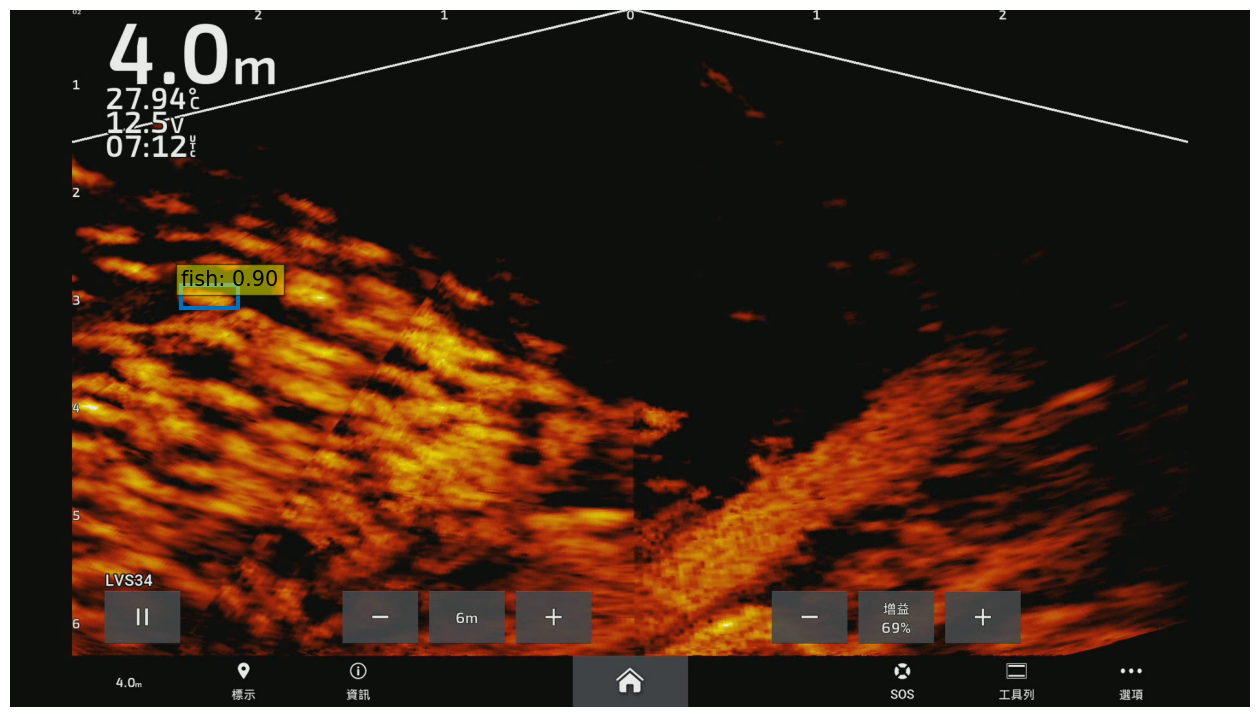

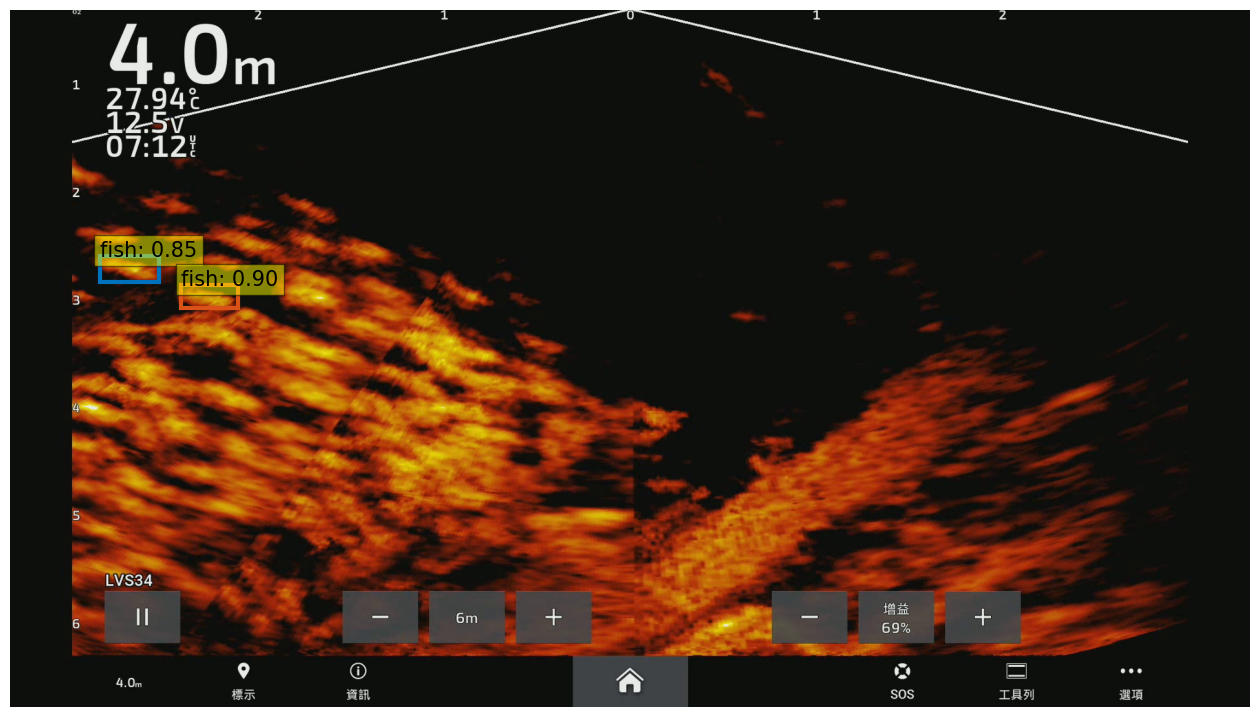

In [27]:
from PIL import Image

img_name = '2023_09_12_57.png'
im = Image.open(img_name)

run_worflow(im, model)

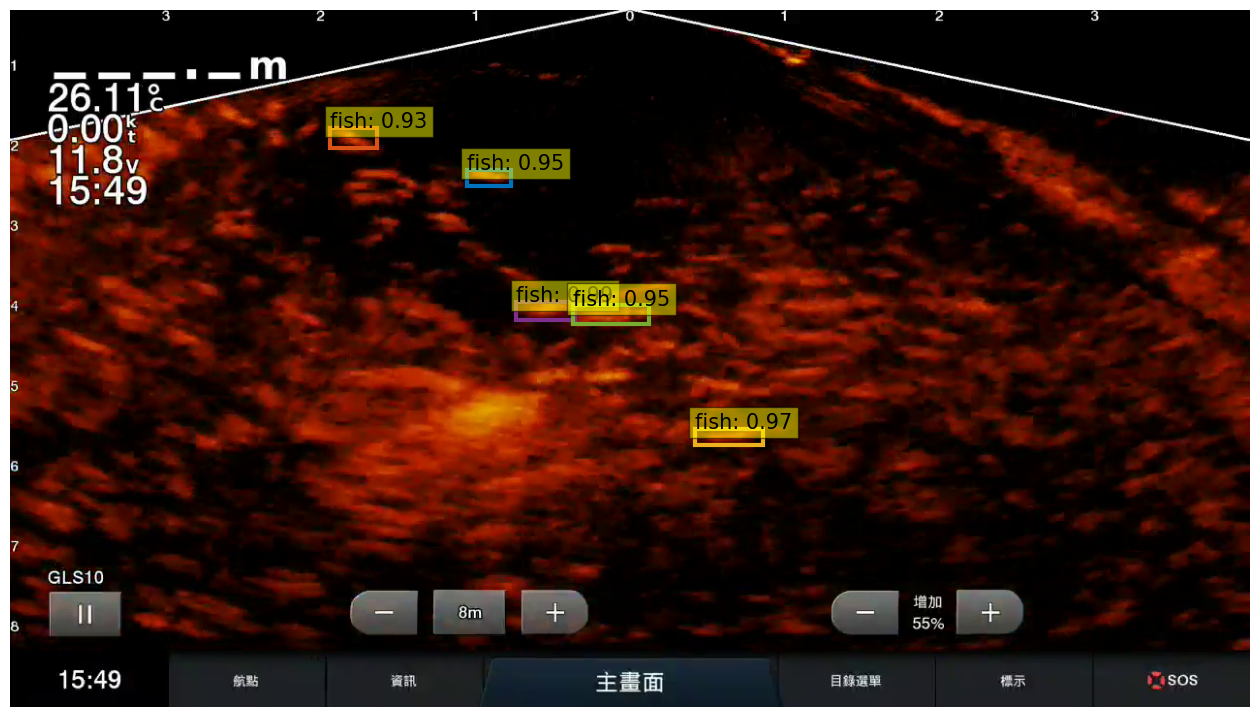

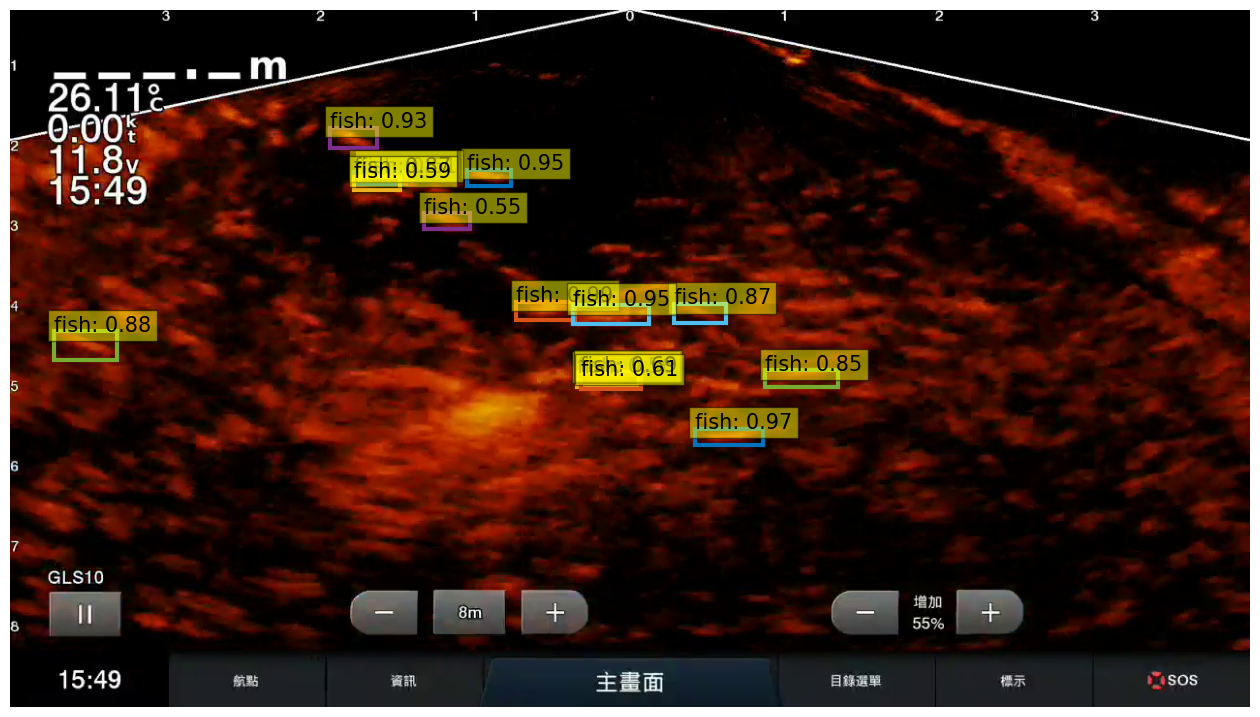

In [28]:
from PIL import Image

img_name = '210809_PengHu-00000234.png'
im = Image.open(img_name)

run_worflow(im, model)


In [29]:
from util.plot_utils import plot_logs

from pathlib import Path
log_floder = 'weight\\outputs\\'
log_directory = [Path(log_floder)]

10/16/2023 10:09:03 - INFO - numexpr.utils -   Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
10/16/2023 10:09:03 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

# hangging face transformers & Pytorch lightning 

* 參考資料
    * https://huggingface.co/docs/huggingface_hub/quick-start
    * https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb

In [ ]:
%pip install huggingface_hub
%pip install lightning

In [1]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [3]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_p = r'C:\Users\samel\Documents\ntou_workplace\data\analysingdata\5fold\evaldata\train2017'
val_p = r'C:\Users\samel\Documents\ntou_workplace\data\analysingdata\5fold\evaldata\val2017'
train_dataset = CocoDetection(img_folder=train_p, processor=processor)
val_dataset = CocoDetection(img_folder=val_p, processor=processor, train=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 93
Number of validation examples: 11


Image n°92


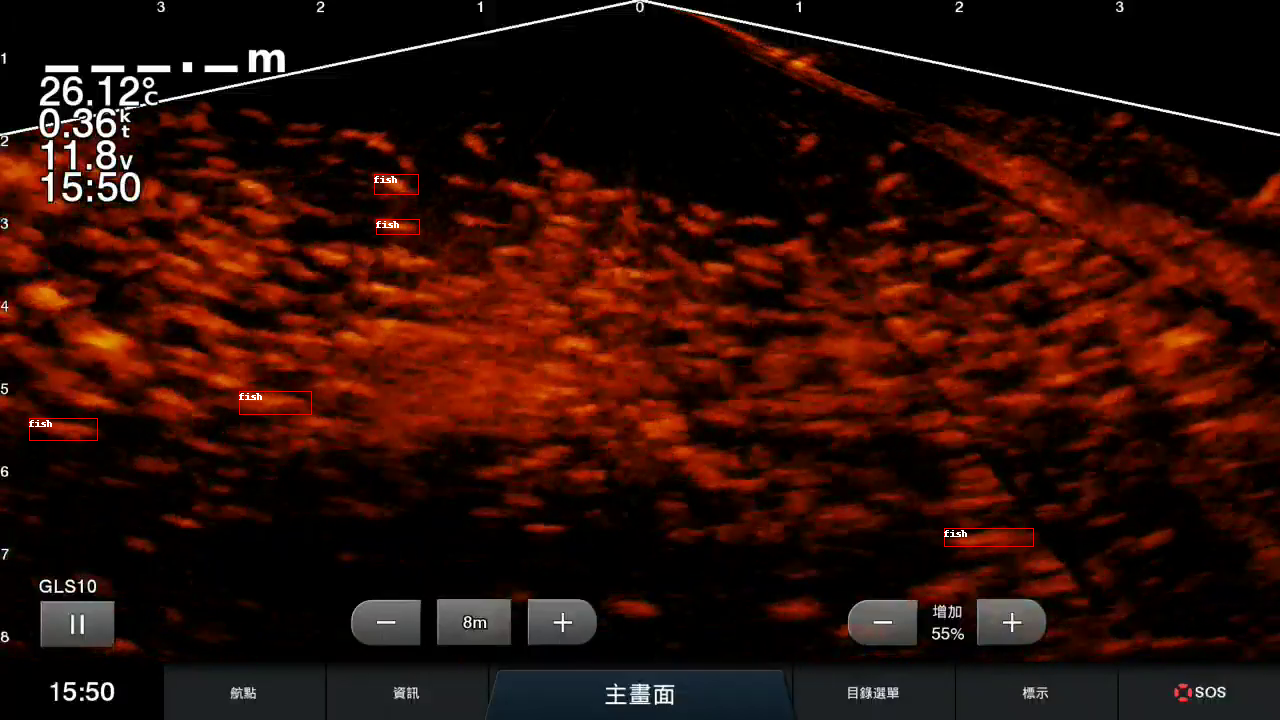

In [5]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(train_p, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [7]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [8]:
pixel_values, target = train_dataset[0]

In [9]:
pixel_values.shape

torch.Size([3, 750, 1333])

In [10]:
print(target)

{'size': tensor([ 750, 1333]), 'image_id': tensor([1]), 'class_labels': tensor([0, 0, 0, 0]), 'boxes': tensor([[0.3851, 0.4967, 0.0462, 0.0388],
        [0.1175, 0.4169, 0.0400, 0.0442],
        [0.2772, 0.4097, 0.0358, 0.0327],
        [0.1818, 0.2432, 0.0443, 0.0416]]), 'area': tensor([ 758.3945,  867.8386,  620.9867, 1080.4590]), 'iscrowd': tensor([0, 0, 0, 0]), 'orig_size': tensor([1080, 1920])}


In [ ]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch


class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50",
            revision="no_timm",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True,
        )
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(
            pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels
        )

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [
                    p
                    for n, p in self.named_parameters()
                    if "backbone" not in n and p.requires_grad
                ]
            },
            {
                "params": [
                    p
                    for n, p in self.named_parameters()
                    if "backbone" in n and p.requires_grad
                ],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(
            param_dicts, lr=self.lr, weight_decay=self.weight_decay
        )

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [12]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
outputs.logits.shape

torch.Size([4, 100, 2])

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(devices=1, accelerator='gpu', max_steps=5, gradient_clip_val=0.1)
trainer.fit(model)

In [16]:
""" install vscode extensions for gui
Name: Jupyter Notebook Renderers
Id: ms-toolsai.jupyter-renderers
Description: Renderers for Jupyter Notebooks (with plotly, vega, gif, png, svg, jpeg and other such outputs)
Version: 1.0.17
Publisher: Microsoft
VS Marketplace Link: https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter-renderers
"""
from huggingface_hub import notebook_login
notebook_login()

In [17]:
model.model.push_to_hub("labfourzerothree/detr-finetuned-customdataset")
processor.push_to_hub("labfourzerothree/detr-finetuned-customdataset")

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/labfourzerothree/detr-finetuned-customdataset/commit/7c7f041b7f86eb80a15a9579a62ff782c54c95b9', commit_message='Upload processor', commit_description='', oid='7c7f041b7f86eb80a15a9579a62ff782c54c95b9', pr_url=None, pr_revision=None, pr_num=None)

In [18]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("labfourzerothree/detr-finetuned-customdataset", id2label={0:"balloon"})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
processor = DetrImageProcessor.from_pretrained("labfourzerothree/detr-finetuned-customdataset")

c:\Users\samel\anaconda3\envs\ntou_pyvenv\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\samel\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [19]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [20]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/6 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l